# Video Search




## Step 1:  Video library (10 points)

Write a python API  that will download the video and its closed captions from youtube. Make sure to document how one can use your API. Use this to download the following videos from youtube along with thei captions:

https://www.youtube.com/watch?v=wbWRWeVe1XE

https://www.youtube.com/watch?v=FlJoBhLnqko

https://www.youtube.com/watch?v=Y-bVwPRy_no

In [1]:
from pytube import YouTube
from youtube_transcript_api import YouTubeTranscriptApi, NoTranscriptFound
from youtube_transcript_api.formatters import TextFormatter
import os

def download_video(video_id, path):
    """
    Download a video from YouTube using its video ID.

    :param video_id: The YouTube video ID
    :param path: The path where the video will be saved
    """
    url = f"https://www.youtube.com/watch?v={video_id}"
    try:
        yt = YouTube(url)
        stream = yt.streams.get_highest_resolution()
        video_file = stream.download(output_path=path)
        print(f"Download completed! {yt.title} has been downloaded to {path}")
        return yt.title  # Return the title for naming the transcript file
    except Exception as e:
        print(f"Error downloading the video {video_id}: {e}")
        return None

def download_transcript(video_id, title, path):
    """
    Download the transcript for a YouTube video using its video ID.

    :param video_id: The YouTube video ID
    :param title: The title of the video to name the transcript file appropriately
    :param path: The path where the transcript will be saved
    """
    try:
        # Fetch the transcript using the video ID
        transcript = YouTubeTranscriptApi.get_transcript(video_id)
        
        # Format the transcript into plain text
        formatter = TextFormatter()
        text_transcript = formatter.format_transcript(transcript)
        
        # Save the transcript to a file
        safe_title = title.replace('/', '_').replace('\\', '_').replace(':', '_').replace('*', '_').replace('?', '_').replace('"', '_').replace('<', '_').replace('>', '_').replace('|', '_')
        filename = os.path.join(path, f"{safe_title}_transcript.txt")
        with open(filename, "w", encoding="utf-8") as file:
            file.write(text_transcript)
        
        print(f"Transcript downloaded: {filename}")
    except NoTranscriptFound:
        print(f"No transcript found for video: {video_id}")

def main():
    # List of YouTube video IDs
    video_ids = [
        "wbWRWeVe1XE",
        "FlJoBhLnqko",
        "Y-bVwPRy_no"
    ]

    # Folder for downloaded videos and transcripts
    download_folder = "downloaded_videos"

    # Create the folder if it doesn't exist
    if not os.path.exists(download_folder):
        os.makedirs(download_folder)
        print(f"Created folder: {download_folder}")

    # Download video and transcript for each video
    for video_id in video_ids:
        title = download_video(video_id, download_folder)
        if title:  # Only attempt to download the transcript if the video was successfully downloaded
            download_transcript(video_id, title, download_folder)

if __name__ == "__main__":
    main()


Download completed! What Does 'High-Quality' Preschool Look Like? | NPR Ed has been downloaded to downloaded_videos
Transcript downloaded: downloaded_videos\What Does 'High-Quality' Preschool Look Like_ _ NPR Ed_transcript.txt
Download completed! How Green Roofs Can Help Cities | NPR has been downloaded to downloaded_videos
Transcript downloaded: downloaded_videos\How Green Roofs Can Help Cities _ NPR_transcript.txt
Download completed! Why It’s Usually Hotter In A City | Let's Talk | NPR has been downloaded to downloaded_videos
Transcript downloaded: downloaded_videos\Why It’s Usually Hotter In A City _ Let's Talk _ NPR_transcript.txt


## Step 2: Video indexing pipeline (90 points)

In this step you will build and train your models to extract embeddings for the frames of your videos and store the extracted information in a database such as postgres for indexing the videos.

### 2.1 Preprocess the video (15 points)

You can use opencv, ffmpeg, gstreameer, https://pytorchvideo.org/ or any other library to implement the preprocessing steps as shown below:
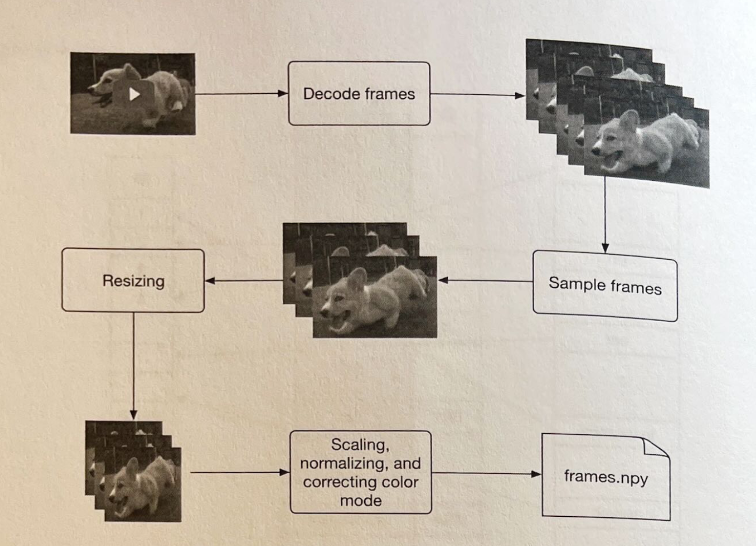



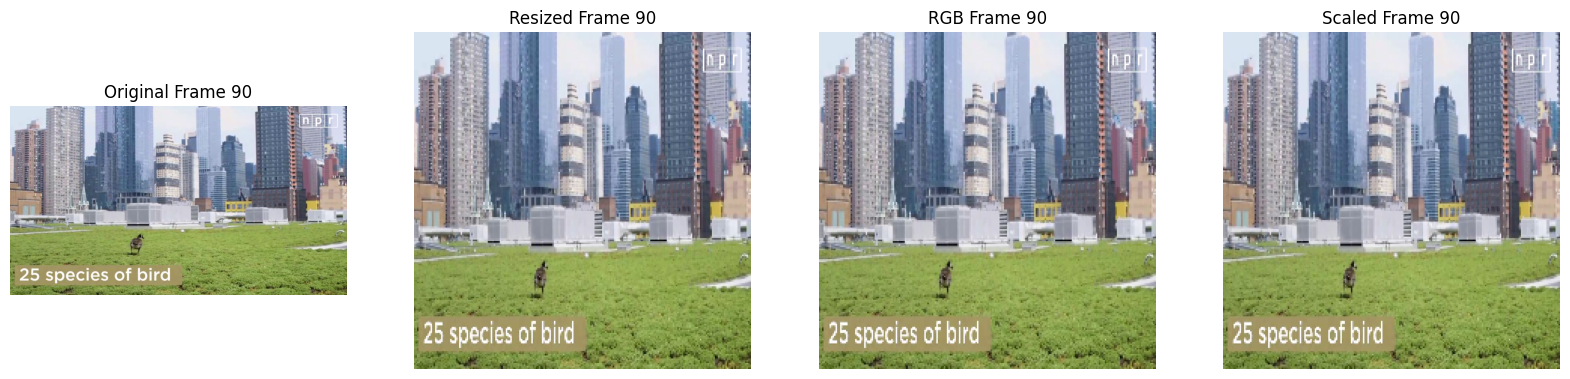

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

def preprocess_and_display_video_steps_side_by_side(video_path, frame_size, sample_interval):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    sample_frame_indices = range(0, frame_count, sample_interval)
    
    for i in sample_frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break
        
        # Prepare the figure
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # Adjust figure size as needed
        
        # Original Frame
        axs[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        axs[0].set_title(f"Original Frame {i}")
        axs[0].axis('off')
        
        # Resize the frame
        resized_frame = cv2.resize(frame, frame_size)
        # Resized Frame
        axs[1].imshow(cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB))
        axs[1].set_title(f"Resized Frame {i}")
        axs[1].axis('off')
        
        # Convert color from BGR to RGB
        rgb_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
        # RGB Frame
        axs[2].imshow(rgb_frame)
        axs[2].set_title(f"RGB Frame {i}")
        axs[2].axis('off')
        
        # Scale pixel values to [0, 1]
        scaled_frame = rgb_frame / 255.0
        # Scaled Frame
        axs[3].imshow(scaled_frame)
        axs[3].set_title(f"Scaled Frame {i}")
        axs[3].axis('off')
        
        # Show the plot
        plt.show()
        clear_output(wait=True)
    
    # Release the video capture object
    cap.release()

# Define parameters for preprocessing
video_path = 'test2.mp4'  # Make sure this path is correct
frame_size = (224, 224)  # Example size, adjust as needed
sample_interval = 30  # Increase interval to speed up demo

# Run the preprocessing and display function
preprocess_and_display_video_steps_side_by_side(video_path, frame_size, sample_interval)


### 2.2 Detecting objects (25 points)

Use any of the pretrained object-detectors to detect objects belonging to MS COCO classes.
For each video, for each frame where a detection is found, compile and report the results in the following tabular structure :

[vidId, frameNum, timestamp, detectedObjId, detectedObjClass, confidence, bbox info]

Feel free to finetune your detectors if required. If you notice that your model performs better on a different video from this [channel](https://www.youtube.com/@NPR), document this and you can use this video for the rest of this assignment.



In [2]:
import torch
import torchvision.transforms as T
import cv2
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import pandas as pd
import numpy as np
import time

# Load a pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Define the transformation
transform = T.Compose([T.ToPILImage(), T.Resize(300), T.ToTensor()])

# MS COCO label map for a subset of common classes
label_map = {
    1: "person", 2: "bicycle", 3: "car", 4: "motorcycle",
    5: "airplane", 6: "bus", 7: "train", 8: "truck",
    9: "boat", 10: "traffic light", 11: "fire hydrant",
    13: "stop sign", 14: "parking meter", 15: "bench",
    16: "bird", 17: "cat", 18: "dog", 19: "horse",
    20: "sheep", 21: "cow", 22: "elephant", 23: "bear",
    24: "zebra", 25: "giraffe", 27: "backpack", 28: "umbrella",
    31: "handbag", 32: "tie", 33: "suitcase", 34: "frisbee",
    35: "skis", 36: "snowboard", 37: "sports ball", 38: "kite",
    39: "baseball bat", 40: "baseball glove", 41: "skateboard",
    42: "surfboard", 43: "tennis racket", 44: "bottle",
    46: "wine glass", 47: "cup", 48: "fork", 49: "knife",
    50: "spoon", 51: "bowl", 52: "banana", 53: "apple",
    54: "sandwich", 55: "orange", 56: "broccoli", 57: "carrot",
    58: "hot dog", 59: "pizza", 60: "donut", 61: "cake",
    62: "chair", 63: "couch", 64: "potted plant", 65: "bed",
    67: "dining table", 70: "toilet", 72: "tv", 73: "laptop",
    74: "mouse", 75: "remote", 76: "keyboard", 77: "cell phone",
    78: "microwave", 79: "oven", 80: "toaster", 81: "sink",
    82: "refrigerator", 84: "book", 85: "clock", 86: "vase",
    87: "scissors", 88: "teddy bear", 89: "hair drier", 90: "toothbrush"
}

def detect_objects(frame):
    # Transform the frame
    frame = transform(frame)
    # Add a batch dimension
    frame = frame.unsqueeze(0)
    
    with torch.no_grad():
        prediction = model(frame)
    
    return prediction

def process_video(video_path, skip_frames=5):
    cap = cv2.VideoCapture(video_path)
    frameNum = 0
    fps = cap.get(cv2.CAP_PROP_FPS)  # Frame rate of the video
    detections_list = []  # List to store detection results
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        if frameNum % skip_frames == 0:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            detections = detect_objects(frame_rgb)[0]
            
            for i in range(len(detections['labels'])):
                score = detections['scores'][i].item()
                if score > 0.5:  # Confidence threshold
                    label_id = detections['labels'][i].item()
                    label = label_map.get(label_id, 'Unknown')
                    box = detections['boxes'][i].numpy().astype(int)
                    timestamp = frameNum / fps
                    
                    # Draw the bounding box and label on the frame
                    cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
                    cv2.putText(frame, f'{label}: {score:.2f}', (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                    
                    detections_list.append([
                        video_path, frameNum, timestamp, label_id, label, score, box.tolist()
                    ])
            
            # Display the frame
            cv2.imshow('Video', frame)
            # Press 'q' to quit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        
        frameNum += 1
    
    cap.release()
    cv2.destroyAllWindows()
    return pd.DataFrame(detections_list, columns=['vidId', 'frameNum', 'timestamp', 'detectedObjId', 'detectedObjClass', 'confidence', 'bbox info'])

# Adjust 'skip_frames' as needed to balance speed and detection frequency
detections_df = process_video('test2.mp4', skip_frames=50)


# To save the DataFrame to a CSV file
detections_df.to_csv('detections.csv', index=False)

# If you wish to print the DataFrame to see the results
print(detections_df.head())


C:\Users\PC\AppData\Local\Temp\ipykernel_10904\3582300657.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.

       vidId  frameNum  timestamp  detectedObjId detectedObjClass  confidence  \
0  test2.mp4         0   0.000000              1           person    0.998434   
1  test2.mp4         0   0.000000             32              tie    0.673472   
2  test2.mp4        50   2.082185             16             bird    0.899095   
3  test2.mp4       100   4.164371             16             bird    0.982059   
4  test2.mp4       100   4.164371             16             bird    0.814012   

              bbox info  
0     [9, 45, 331, 294]  
1  [123, 202, 171, 290]  
2  [447, 104, 471, 131]  
3  [187, 202, 212, 238]  
4  [512, 196, 529, 208]  


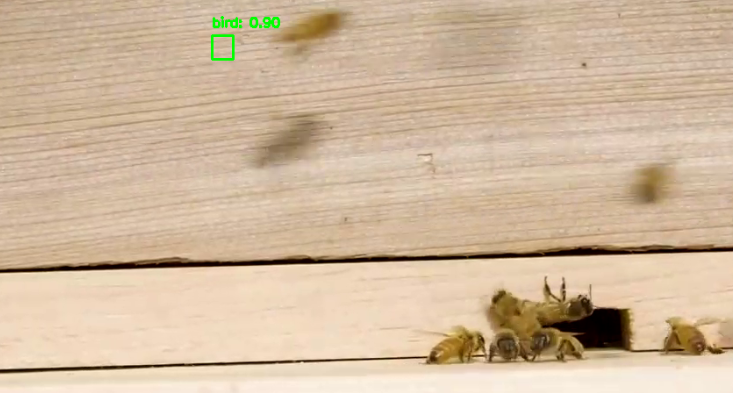
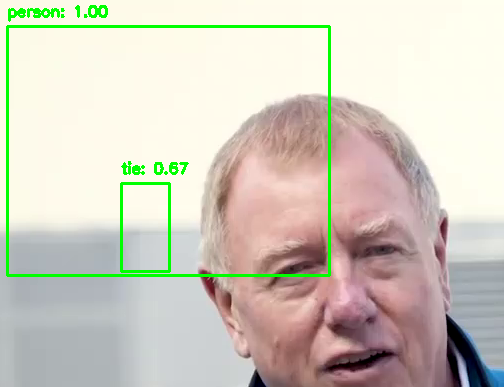

### 2.3 Embedding model (30 points)

Develop a convolutional autoencoder such as [the one described here](https://blog.keras.io/building-autoencoders-in-keras.html) whose input will be all the objects detected in each frame (not the entire frame!), if any.
Note : You can downsample the frame rate of your original video to avoid long training/processing times. For a given input image, the autoencoder should output it's small vector embedding.

Train your autoencoder on the COCO dataset for classes which get detected in the given list of videos.

#### Extra credit (10 points)
Extra credit: if you want to maximize the possibility of developing something **new** think about how a video can be better segmented into representative frames. For example, [in this ~3min video accessed Nov 2023](https://youtu.be/FN8a8mZNik8?si=wXdbOGuLGkGsWsf) you have multiple scenes each one lasting 30sec or so. Can you find a way to segment each video and store the frame embeddings of each segment? This way there are multiple embeddings per video and you need to keep them that way for the subsequesnt steps of this project.

### Indexing the embeddings (20 points)

Use `docker compose` to bring up two docker containers, your application container with the dev environment (you must have done this in Step 1) and a second container with postgres.

`docker pull postgres:latest`

Process all the detected object sub-images for each frame of each video to compile your final results in the following tabular structure:
[vidId, frameNum, timestamp, detectedObjId, detectedObjClass, confidence, bbox info, vector<embedding of this object>, optional<sceneId from extra credit>]

Index the video images embedding vectors in the database. To do that in postgres (with the pgvector extension) you can use [this guide](https://dev.to/sfoteini/image-vector-similarity-search-with-azure-computer-vision-and-postgresql-12f7).

Demonstrate that you can search the database using image queries and post the screenshots of your search results that must include the first 10 similar images across the input videos.
